### Step 0: Get packages and helper functions

In [1]:
# Add source and data file paths
import os
path = os.path.abspath(os.getcwd())
os.chdir("../..")
parent_path = os.path.abspath(os.getcwd())

import sys 
sys.path.insert(1, parent_path + '\\source')
sys.path.insert(2, parent_path + '\\data')

import numpy as np; import torch; import time

# Import source/helper functions
from misc_helper import combine_layers, get_dt, get_userPar, training_loop, make_gif
from plot_helper import reference_plot, sample_plot
from trainingData_helper import generate_trainData
from windowSweep_helper import window_sweep_class
from pde_helper import PDE_class
from neuralNetwork_helper import Net, activation_func_a, weight_class, dtPINN

## Step 1: Define PDE problem and visualize 

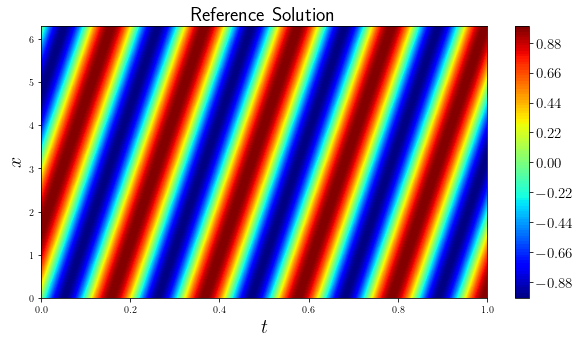

In [2]:
pde_type = 'convection'
newParams = {}

#pde_type = 'new'
#newParams = {}; newParams['data'] = parent_path+'\\data\\convec_10.mat'; newParams['pde'] = 'u_t + 10*u_x'; newParams['IC'] = 'np.sin(x)';

PDE = PDE_class(pde_type, newParams)
dataPar = PDE.data()

# Reference solution
reference_plot(dataPar)

## Step 2: dtPINN user settings

In [3]:
### Neural network parameters
input_encoding = 0 # Boolean for encode input to enforce exact boundary condtions
M = 1; L = get_dt(dataPar['xmin'], dataPar['xmax'], 1) # Hyperparameters for exact BC encoding, not used if turned off
hidden_layers = [50, 50, 50, 50]; layers = combine_layers(input_encoding, M, hidden_layers) # PINN layers
# Note Adam and L-BFGS epoch/iterations are per frame for generating animations, the total amount is multiplied by the training loops defined below
# Will be cutoff early if a new network is added since optimizer needs to be reset via this control loop
adam_params = [500, 0.001] # Optimization Hyperparameters for Adam [epochs, learning rate]
lbfgs_params = [0.1, 500, None, -1, -1, 50] # Optimization Hyperparameters for LBFGS [learning rate, max iterations, max evaluations, tolerance gradient, tolerance change, history size]
adaptive_activation = 0 # Adaptive activation functions in NN
dirichlet_bc = 0 # Use Dirichlet boundary condtions based on reference solution (0 = no, 1 = yes), number of points will depend on reference solution not user-defined N_b
learned_weights = 0 
lambda_w = 100 # Weight applied to non PDE-reisudal loss terms

### Training data parameters
N_x = 100; N_t = 100; N_f = N_x*N_t # Number of collocation points in the ENTIRE domian (pre subdomain partitioning)
N_0 = 200 # Number of initial condtion points in the ENTIRE domain
N_b = 200 # Number of boundary condtion points in the ENTIRE domain
N_i = N_0 # Number of interface continuity points for each interface (total = N_i*(n-1))
collocation_sampling = 'lhs' # Latin-hypercube or grid sampling

### From Algorithm 1 in paper
## 1. Choose stacked-decomposition parameters [n, dS, adaptive dt]
num_partitions = 1; dt = get_dt(dataPar['tmin'], dataPar['tmax'], num_partitions) # Number of time-slabs in domain (1 = PINN) and dt derived from number and t-domain; 
dS = 1 # Number of continuously training segments
causal_dS = 1 # Boolean for adding in intial dS segments causality or not (0 = no, 1 = yes)
stacked_tol = 1*10**(-15)

## 2. Choose interface conditions [residual continuity, Cp continuity, other]
interface_condition = ['u'] # List of interface condtions to add (u = solution continuity, uavg = average solution continuity, residual = minimize residuals, rc = minimize residual continuity)
# [xPINN = 'uavg' + 'rc', C^p continuity = 'u' for first-order systems]

## 3. Choose transfer learning parameters [number of layers, trainability of layers]
# If all layers that are transfered and kept learnable = 'fine-tuning'
# If some layers that are transfered and made unlearnable = 'transfer learning'
layer_transfer = [1, 1, 1, 1, 1] # Boolean mask to transfer weights and bias (length = len(layers) - 1)
layer_trainability = [1, 1, 1, 1, 1] # Boolean mask to make layers continue to be learnable or not (length = len(layers) - 1)

## 4. Choose window-sweeping parameters [weighting scheme, scheme hyperparameters]
#window_scheme = 'erf'
#scheme_parameters = (50, 10**(-8), 10**(-2), 1, 10**(-5)) 
window_scheme = 'none'
scheme_parameters = [2*10**(-1), 10**(-9), 1*10**(-2), 1]
# [(If 'none': , If 'uniform' or 'linear': width, propogate loss tolerance, dt, scale; 
# If 'erf': sharpness, propogate loss tolerance, dt, scale, set cutoff tolerance; 
# If 'causual_weights': epsilon), bound tolerance]

userPar = get_userPar(path, pde_type, input_encoding, M, L, layers, adam_params, lbfgs_params, adaptive_activation, learned_weights, N_x, N_t, N_f, N_0, N_b, N_i, collocation_sampling,\
                     num_partitions, dt, dS, causal_dS, interface_condition, layer_transfer, layer_trainability, window_scheme, scheme_parameters, PDE, stacked_tol, lambda_w, dirichlet_bc)

### Step 2.1: Generate and visualize training data

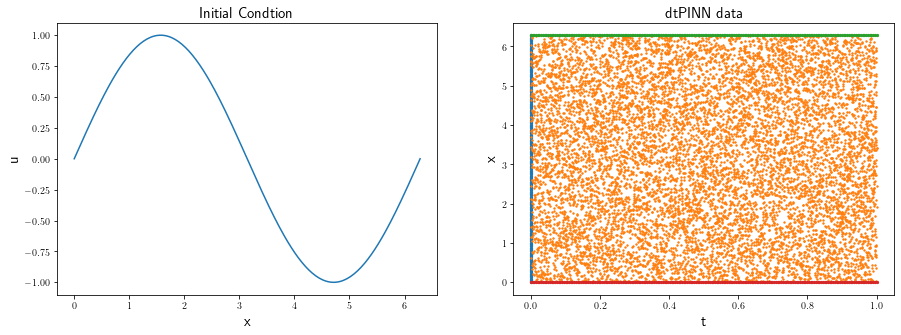

In [4]:
dataPar = generate_trainData(dataPar, userPar)
sample_plot(dataPar, userPar)

## Step 3: Train model and visualize

### Step 3.1: Define training and visualization parameters

In [5]:
### Training visualization parameters
userPar['animation'] = 0; # Boolean for showing/saving snapshots to make animation. If 0, it will just show/save the end of training
userPar['save_fig'] = 1; # Save training figures
userPar['model_name'] = 'convection_motivation_PINN_midTraining_weakBC' # Name of file to save training snapshots under
userPar['show_fig'] = 1; # Display training figures
userPar['verbose'] = 1 # Print out various training varibles at train time such as loss and iterations
SEED = 0

### Step 3.2: Initalize the model

In [6]:
print('SEED:', SEED); torch.manual_seed(SEED); np.random.seed(SEED);
model = dtPINN(dataPar, userPar)

SEED: 0


### Step 3.3: Train the model

dtPINN
Train Adam:
epoch 100, loss: 37.7313
epoch 200, loss: 15.6332
epoch 300, loss: 8.20181
epoch 400, loss: 5.1878
epoch 500, loss: 3.46893
Training time: 34.8113
Train L-BFGS:
epoch 100, loss: 2.61009, delta loss: 0.0102966
epoch 200, loss: 1.9886, delta loss: 0.00579369
epoch 300, loss: 1.58391, delta loss: 0.00308239
epoch 400, loss: 1.2595, delta loss: 0.000843287
epoch 500, loss: 1.15069, delta loss: 0.00143671
Training time: 70.4209
Train L-BFGS:
epoch 100, loss: 1.02139, delta loss: 0.00177228
epoch 200, loss: 0.925998, delta loss: 0.000922084
epoch 300, loss: 0.851306, delta loss: 0.000508547
epoch 400, loss: 0.821389, delta loss: 0.000199735
epoch 500, loss: 0.803482, delta loss: 0.00014019
Training time: 106.7923
Train L-BFGS:
epoch 100, loss: 0.781924, delta loss: 0.000166237
epoch 200, loss: 0.755163, delta loss: 0.000336587
epoch 300, loss: 0.724238, delta loss: 0.000206709
epoch 400, loss: 0.701713, delta loss: 0.000139534
epoch 500, loss: 0.687031, delta loss: 0.00011

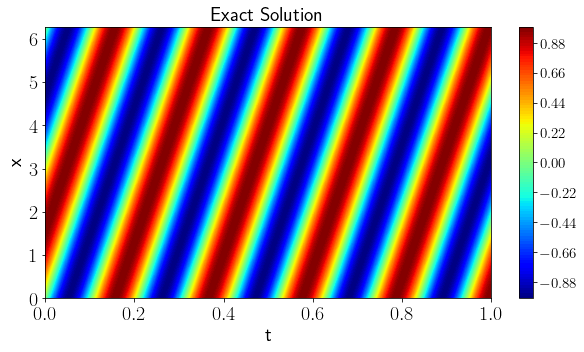

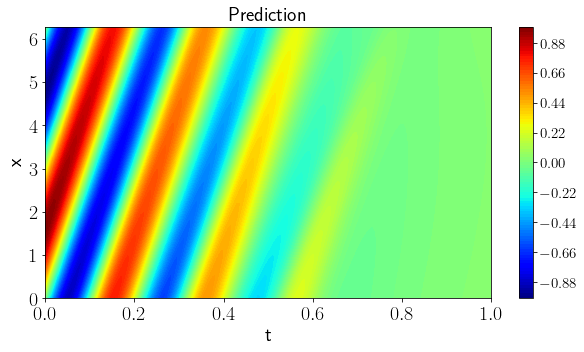

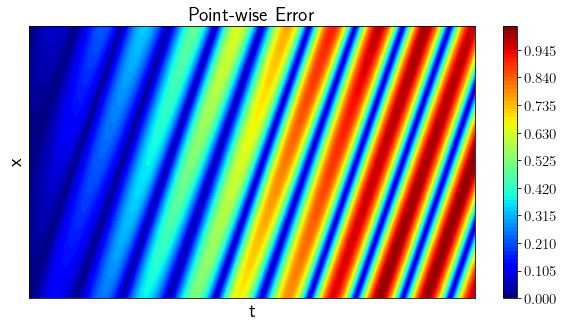

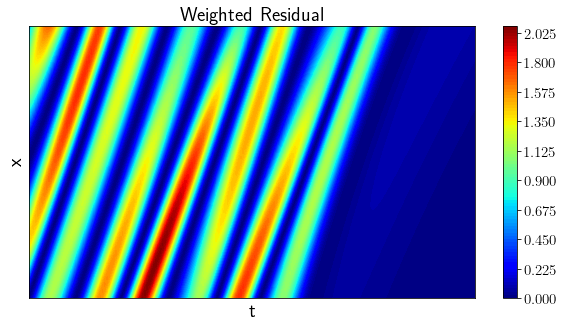

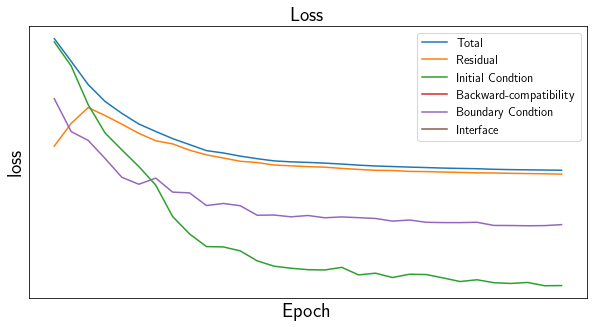

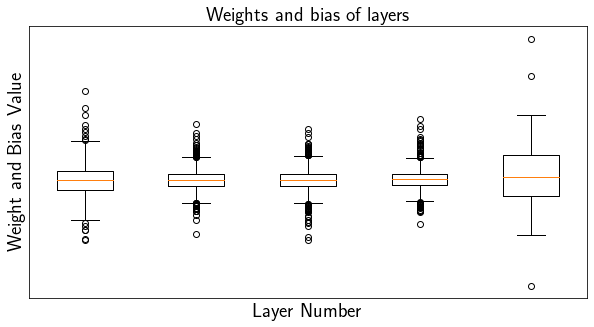

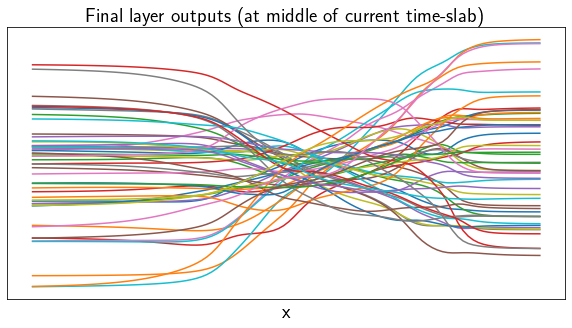

L2-error:  0.7105755781110296


In [7]:
adam_loops = 1
lbfgs_loops = 5
model = training_loop(userPar, dataPar, model, adam_loops, lbfgs_loops)